### Human in the loop : Interrupt

* Interrupt for input
* Suspend while waiting
* Resume

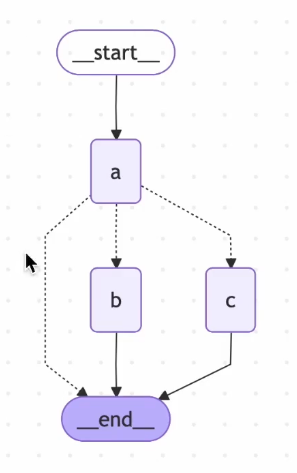

In [3]:
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt

In [4]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()
config = {"configurable": {"thread_id": "1"}}

In [5]:
class State(TypedDict):
    nlist: Annotated[list[str], operator.add]

In [7]:
def node_a(state: State) -> Command[Literal["b", "c", END]]:
    print("Entered 'a' node")
    select = state["nlist"][-1]
    if select == "b":
        next_node = "b"
    elif select == "c":
        next_node = "c"
    elif select == "q":
        next_node = END
    else:
        admin = interrupt(f"Unexpected input '{select}'")
        print(admin)
        if admin == "continue":
            next_node = "b"
        else:
            next_node = END
            select = "q"

    return Command(
        update = State(nlist = [select]),
        goto = next_node
    )

def node_b(state: State) -> State:
    return(State(nlist = ["B"]))

def node_c(state: State) -> State:
    return(State(nlist = ["C"]))

In [8]:
builder = StateGraph(State)

# Add nodes -
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)

# Add edges -
builder.add_edge(START, "a")
builder.add_edge("b", END)
builder.add_edge("c", END)

# Compile - 
graph = builder.compile(checkpointer=memory)

In [11]:
while True:
    user = input('b, c, or q to quit: ')
    input_state = State(nlist = [user])
    result = graph.invoke(input_state, config)

    if '__interrupt__' in result:
        print("Interrupt: {result}")
        msg = result['__interrupt__'][-1].value
        print(msg)
        human = input(f"\n{msg}: ")

        human_response = Command(
            resume = human
        )
        result = graph.invoke(human_response, config)

    if result['nlist'][-1] == "q":
        print("quit")
        break

b, c, or q to quit:  p


Entered 'a' node
Interrupt: {result}
Unexpected input 'p'



Unexpected input 'p':  continue


Entered 'a' node
continue


b, c, or q to quit:  q


Entered 'a' node
quit
